# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [22]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df.head()


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [23]:
# TODO: write 1-2 sentences: what is the grain of this dataset?
# The grain of this dataset is at the user level, where each row represents a unique user with their associated attributes and behaviors.

# TODO: inspect dtypes; convert to appropriate types if needed
df.dtypes
# Convert categorical columns to 'category' dtype
categorical_cols = ['country', 'plan', 'last_payment_failed', 'refund_after_churn_flag']

# HINT: churned should be int/bool; categorical columns should remain object/category

for col in categorical_cols:
    df[col] = df[col].astype('category')
df['churned'] = df['churned'].astype(int)   
df.dtypes


user_id                       int64
country                    category
plan                       category
signup_days_ago               int64
tenure_days                   int64
sessions_last_7d              int64
avg_session_min             float64
age                         float64
discount_pct                float64
last_payment_failed        category
churned                       int64
refund_after_churn_flag    category
dtype: object

### Task 1.2: Missingness + duplicates


In [24]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    pct_missing = (missing / len(df)) * 100
    return pd.DataFrame({'n_missing': missing, 'pct_missing': pct_missing}).sort_values('pct_missing', ascending=False)

miss = missingness_table(df)
miss

check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
#n_dup_rows = None
#n_dup_user_id = None
n_dup_rows = df.duplicated().sum()
n_dup_user_id = df['user_id'].duplicated().sum()
print(n_dup_rows, n_dup_user_id)


OK: miss_has_cols
0 0


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [25]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns
num = df.select_dtypes(include=[np.number])
summary = num.describe().T
summary = None
summary


### Task 2.2: Plot 2 high-signal distributions


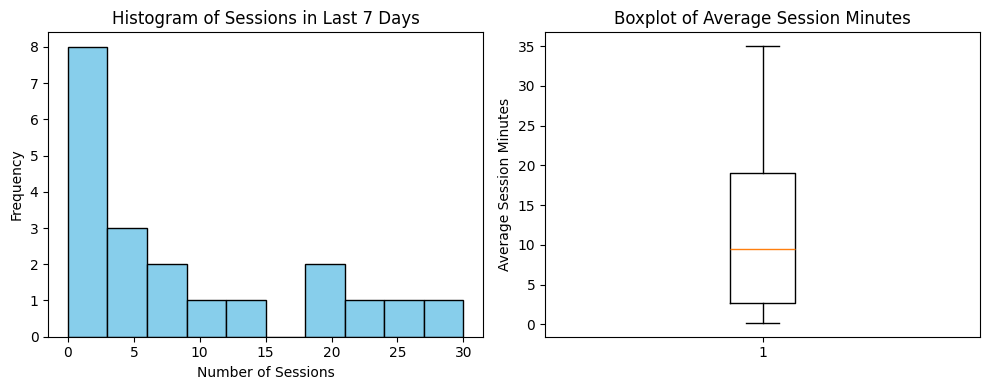

In [26]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['sessions_last_7d'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Sessions in Last 7 Days')
plt.xlabel('Number of Sessions')
plt.ylabel('Frequency')
# TODO
plt.subplot(1,2,2)
plt.boxplot(df['avg_session_min'].dropna(), vert=True)
plt.title('Boxplot of Average Session Minutes')
plt.ylabel('Average Session Minutes')
# TODO
plt.tight_layout()
plt.show()



## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [27]:
# TODO: compute churn rate and counts
churn_rate = df['churned'].mean()
counts = df['churned'].value_counts()
print(churn_rate)
counts

# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why?


0.3


churned
0    14
1     6
Name: count, dtype: int64

### Task 3.2: Slice analysis


In [28]:
# TODO: compute churn rate by country and by plan
by_country = df.groupby('country',observed=True)['churned'].mean()
by_plan = df.groupby('plan',observed=True)['churned'].mean()
by_country
by_plan

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut
df2 = df.copy()
df2["tenure_bucket"] = None
df2["tenure_bucket"] = pd.cut(df2["tenure_days"], bins=[0,30,90,180,365,800], labels=["0-30","31-90","91-180","181-365","366+"])
by_bucket = df2.groupby('tenure_bucket',observed=True)['churned'].mean()
by_bucket


tenure_bucket
0-30       0.833333
31-90      0.000000
91-180     0.333333
181-365    0.000000
366+       0.000000
Name: churned, dtype: float64

## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [29]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
leaky_cols = ['last_payment_failed', 'refund_after_churn_flag']
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability).
# The 'last_payment_failed' column is leaky because it indicates whether the user's last payment attempt was unsuccessful, which is information that would only be available after the churn event has occurred. Therefore, using this feature for prediction would lead to data leakage. Similarly, the 'refund_after_churn_flag' column is leaky because it directly indicates whether a refund was issued after the user churned. This information is inherently tied to the outcome we are trying to predict (churn) and would not be known at the time of prediction, making it unsuitable for use in a predictive model.


['last_payment_failed', 'refund_after_churn_flag']

## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks
- Top 3 features to create next
- What you would do before training any model
